# Hazard class

A Hazard contains the following information:

- tag (TagHazard): information about the source
- units (str): units of the intensity
- centroids (Centroids): centroids of the events
- event_id (np.array): id (>0) of each event
- event_name (list(str)): name of each event (default: event_id)
- date (np.array): integer date corresponding to the proleptic Gregorian ordinal, where January 1 of year 1 has ordinal 1 (ordinal format of datetime library)
- frequency (np.array): frequency of each event in seconds
- orig (np.array): flags indicating historical events (True) or probabilistic (False)
- intensity (sparse.csr_matrix): intensity of the events at centroids
- fraction (sparse.csr_matrix): fraction of affected exposures for each event at each centroid

Note that `intensity` and `fraction` are scipy.sparse matrices of size num_events x num_centroids. The `Centroids` class contains the geographical coordinates where the hazard is defined. A `Centroids` instance provides the coordinates either as points or raster data together with their Coordinate Reference System (CRS). The default CRS used in climada is the usual EPSG:4326. `Centroids` provides moreover methods to compute centroids areas, on land mask, country iso mask or distance to coast.

## Read raster data

Raster data can be read in any format accepted by [rasterio](https://rasterio.readthedocs.io/en/stable/) using `Hazard`'s `set_raster()` method. The raster information might refere to the `intensity` or `fraction`of the hazard. Different configuration options such as transforming the coordinates, changing the CRS and reading only a selected area or band are available through the `set_raster()` arguments as follows:

2019-10-29 21:57:09,546 - climada - DEBUG - Loading default config file: /Users/aznarsig/Documents/Python/climada_python/climada/conf/defaults.conf
2019-10-29 21:57:12,428 - climada.util.coordinates - INFO - Reading /Users/aznarsig/Documents/Python/climada_python/data/demo/SC22000_VE__M1.grd.gz


/Users/aznarsig/Documents/Python/climada_python/climada/util/plot.py:318: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


event_id:  [1]
event_name:  ['1']
date:  [1.]
frequency:  [0.5]
orig:  [ True]
min, max fraction:  0.0 1.0


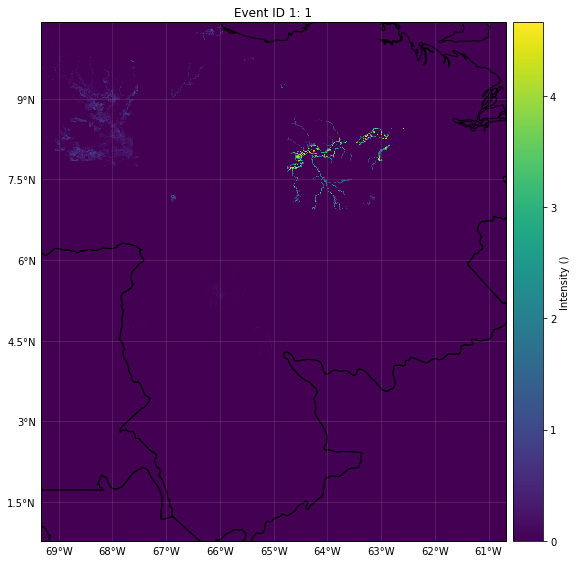

In [1]:
%matplotlib inline
import numpy as np
from climada.hazard import Hazard
from climada.util.constants import HAZ_DEMO_FL

haz_ven = Hazard('FL')
# read intensity from raster file HAZ_DEMO_FL and set frequency for the contained event
haz_ven.set_raster([HAZ_DEMO_FL], attrs={'frequency':np.ones(1)/2})
haz_ven.check()

# The masked values of the raster are set to 0
# Sometimes the raster file does not contain all the information, as in this case the mask value -9999
# We mask it manuall and plot it using plot_intensity()
haz_ven.intensity[haz_ven.intensity==-9999] = 0
haz_ven.plot_intensity(1, smooth=False) # if smooth=True (default value) is used, the computation time might increase

# per default the following attributes have been set
print('event_id: ', haz_ven.event_id)
print('event_name: ', haz_ven.event_name)
print('date: ', haz_ven.date)
print('frequency: ', haz_ven.frequency)
print('orig: ', haz_ven.orig)
print('min, max fraction: ', haz_ven.fraction.min(), haz_ven.fraction.max())

### EXERCISE:

1. Read raster data in EPSG 2201 Coordinate Reference System (CRS)
2. Read raster data in its given CRS and transform it to the affine transformation Affine(0.009000000000000341, 0.0, -69.33714959699981, 0.0, -0.009000000000000341, 10.42822096697894), height=500, width=501)
3. Read raster data in window Window(10, 10, 20, 30)

In [2]:
# Put your code here





In [3]:
# Solution:

# 1. The CRS can be reprojected using dst_crs option
haz = Hazard('FL')
haz.set_raster([HAZ_DEMO_FL], dst_crs={'init':'epsg:2201'}) 
haz.check()
print('\n Solution 1:')
print('centroids CRS:', haz.centroids.crs)
print('raster info:', haz.centroids.meta)

# 2. Transformations of the coordinates can be set using the transform option and Affine 
from rasterio import Affine
haz = Hazard('FL')
haz.set_raster([HAZ_DEMO_FL], transform=Affine(0.009000000000000341, 0.0, -69.33714959699981, \
                                               0.0, -0.009000000000000341, 10.42822096697894), height=500, width=501) 
haz.check()
print('\n Solution 2:')
print('raster info:', haz.centroids.meta)
print('intensity size:', haz.intensity.shape)

# 3. A partial part of the raster can be loaded using the window or geometry
from rasterio.windows import Window
haz = Hazard('FL')
haz.set_raster([HAZ_DEMO_FL], window=Window(10, 10, 20, 30))
haz.check()
print('\n Solution 3:')
print('raster info:', haz.centroids.meta)
print('intensity size:', haz.intensity.shape)

2019-10-29 21:57:18,056 - climada.util.coordinates - INFO - Reading /Users/aznarsig/Documents/Python/climada_python/data/demo/SC22000_VE__M1.grd.gz

 Solution 1:
centroids CRS: {'init': 'epsg:2201'}
raster info: {'driver': 'GSBG', 'dtype': 'float32', 'nodata': 1.701410009187828e+38, 'width': 978, 'height': 1091, 'count': 1, 'crs': {'init': 'epsg:2201'}, 'transform': Affine(1011.5372910988809, 0.0, 1120744.548666424,
       0.0, -1011.5372910988809, 1189133.7652687668)}
2019-10-29 21:57:20,357 - climada.util.coordinates - INFO - Reading /Users/aznarsig/Documents/Python/climada_python/data/demo/SC22000_VE__M1.grd.gz

 Solution 2:
raster info: {'driver': 'GSBG', 'dtype': 'float32', 'nodata': 1.701410009187828e+38, 'width': 501, 'height': 500, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.009000000000000341, 0.0, -69.33714959699981,
       0.0, -0.009000000000000341, 10.42822096697894)}
intensity size: (1, 250500)
2019-10-29 21:57:22,513 - climada.util.coordinat

## Read other formats

- excel: Hazards can be read from Excel files following the template in `climada_python/data/system/hazard_template.xlsx` using the `read_excel()` method. 
- MATLAB: Hazards generated with CLIMADA's MATLAB version (.mat format) can be read using `read_mat()`.
- vector data: Use `Hazard`'s `set_vector()` to read shape data (all formats supported by [fiona](https://fiona.readthedocs.io/en/latest/manual.html)).
- hdf5: Hazards generated with the CLIMADA in Python (.h5 format) can be read using `read_hdf5()`.

In [4]:
from climada.hazard import Hazard
from climada.util import HAZ_DEMO_H5 # CLIMADA's Python file
# Hazard needs to know the acronym of the hazard type to be constructed!!! Use 'NA' if not known.
haz_tc_fl = Hazard('TC')
haz_tc_fl.read_hdf5(HAZ_DEMO_H5)  # Historic and synthetic tropical cyclones in Florida from 1975 to 2011
haz_tc_fl.check() # Use always the check() method to see if the hazard has been loaded correctly

2019-10-29 21:57:22,545 - climada.hazard.base - INFO - Reading /Users/aznarsig/Documents/Python/climada_python/data/demo/tc_fl_1975_2011.h5


## Define a Hazard by hand

A `Hazard` can be defined by filling its values one by one, as follows:

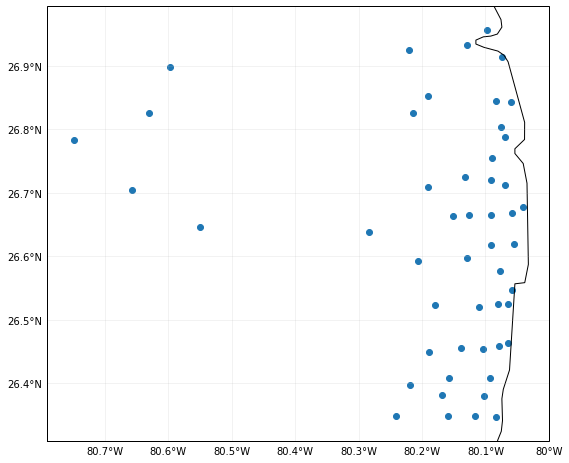

In [5]:
# setting points 
import numpy as np
from scipy import sparse

lat = np.array([26.933899, 26.957203, 26.783846, 26.645524, 26.897796, 26.925359, \
       26.914768, 26.853491, 26.845099, 26.82651 , 26.842772, 26.825905, \
       26.80465 , 26.788649, 26.704277, 26.71005 , 26.755412, 26.678449, \
       26.725649, 26.720599, 26.71255 , 26.6649  , 26.664699, 26.663149, \
       26.66875 , 26.638517, 26.59309 , 26.617449, 26.620079, 26.596795, \
       26.577049, 26.524585, 26.524158, 26.523737, 26.520284, 26.547349, \
       26.463399, 26.45905 , 26.45558 , 26.453699, 26.449999, 26.397299, \
       26.4084  , 26.40875 , 26.379113, 26.3809  , 26.349068, 26.346349, \
       26.348015, 26.347957])

lon = np.array([-80.128799, -80.098284, -80.748947, -80.550704, -80.596929, \
       -80.220966, -80.07466 , -80.190281, -80.083904, -80.213493, \
       -80.0591  , -80.630096, -80.075301, -80.069885, -80.656841, \
       -80.190085, -80.08955 , -80.041179, -80.1324  , -80.091746, \
       -80.068579, -80.090698, -80.1254  , -80.151401, -80.058749, \
       -80.283371, -80.206901, -80.090649, -80.055001, -80.128711, \
       -80.076435, -80.080105, -80.06398 , -80.178973, -80.110519, \
       -80.057701, -80.064251, -80.07875 , -80.139247, -80.104316, \
       -80.188545, -80.21902 , -80.092391, -80.1575  , -80.102028, \
       -80.16885 , -80.116401, -80.08385 , -80.241305, -80.158855])

n_cen = lon.size # number of centroids
n_ev = 10 # number of events

haz = Hazard('TC')
haz.centroids.set_lat_lon(lat, lon) # default crs used
haz.intensity = sparse.csr_matrix(np.random.random((n_ev, n_cen)))
haz.units = 'm'
haz.event_id = np.arange(n_ev, dtype=int)
haz.event_name = ['ev_12', 'ev_21', 'Maria', 'ev_35', 'Irma', 'ev_16', 'ev_15', 'Edgar', 'ev_1', 'ev_9']
haz.date = [721166, 734447, 734447, 734447, 721167, 721166, 721167, 721200, 721166, 721166]
haz.orig = np.zeros(n_ev, bool)
haz.frequency = np.ones(n_ev)/n_ev
haz.fraction = haz.intensity.copy()
haz.fraction.data.fill(1)
haz.check()
haz.centroids.plot()

Check centroids borders: (-72.0, -3.0, -52.0, 22.0)
Check centroids borders: (-72.25, -3.25, -51.75, 22.25)


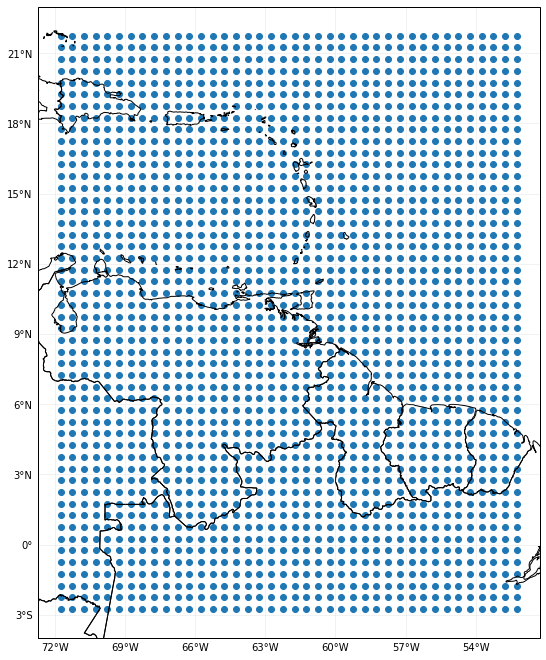

In [6]:
# setting raster 
import numpy as np
from scipy import sparse

# raster info:
# border upper left corner (of the pixel, not of the center of the pixel)
xf_lat = 22
xo_lon = -72
# resolution in lat and lon
d_lat = -0.5 # negative because starting in upper corner
d_lon = 0.5 # same step as d_lat
# number of points
n_lat = 50
n_lon = 40

n_ev = 10 # number of events

haz = Hazard('TC')
haz.centroids.set_raster_from_pix_bounds(xf_lat, xo_lon, d_lat, d_lon, n_lat, n_lon) # default crs used
haz.intensity = sparse.csr_matrix(np.random.random((n_ev, haz.centroids.size)))
haz.units = 'm'
haz.event_id = np.arange(n_ev, dtype=int)
haz.event_name = ['ev_12', 'ev_21', 'Maria', 'ev_35', 'Irma', 'ev_16', 'ev_15', 'Edgar', 'ev_1', 'ev_9']
haz.date = [721166, 734447, 734447, 734447, 721167, 721166, 721167, 721200, 721166, 721166]
haz.orig = np.zeros(n_ev, bool)
haz.frequency = np.ones(n_ev)/n_ev
haz.fraction = haz.intensity.copy()
haz.fraction.data.fill(1)
haz.check()
print('Check centroids borders:', haz.centroids.total_bounds)
haz.centroids.plot()

# using set_raster_from_pnt_bounds, the bounds refer to the bounds of the center of the pixel
left, bottom, right, top = xo_lon, -3.0, -52.0, xf_lat
haz.centroids.set_raster_from_pnt_bounds((left, bottom, right, top), 0.5) # default crs used
print('Check centroids borders:', haz.centroids.total_bounds)

## Methods

The following methods can be used to analyse the data in `Hazard`:

- `calc_year_set()` method returns a dictionary with all the historical (not synthetic) event ids that happened at each year. 
- `get_event_date()` returns strings of dates in ISO format.
- To obtain the relation between event ids and event names, two methods can be used `get_event_name()` and `get_event_id()`. 

Other methods to handle one or several Hazards are:
- the property `size` returns the number of events contained.
- `append()` is used to expand events with data from another `Hazard` (and sam centroids).
- `select()` returns a new hazard with the selected region, date and/or synthetic or historical filter.
- `remove_duplicates()`: removes events with same name and date.
- `local_exceedance_inten()` returns a matrix with the exceedence frequency at every frequency and provided return periods. This is the one used in `plot_rp_intensity()`.
- `reproject_raster()`, `reproject_vector()`, `raster_to_vector()`, `vector_to_raster()`: methods to change centroids' CRS and between raster and vector data. 

`Centroids` methods:
- centroids properties such as area per pixel, distance to coast, country ISO code, on land mask or elevation are available through differen `set_XX()`methods.
- `set_lat_lon_to_meta()` computes the raster `meta` dictionary from present lat and lon. `set_meta_to_lat_lon()` computes lat and lon of the center of the pixels described in attribute `meta`. The raster `meta` information contains at least: `width`, `height`, `crs` and `transform` data (use help(Centroids) for more info). Using raster centroids can increase computing performance for several computations.
- when using lats and lons (vector data) the `geopandas.GeoSeries` `geometry` attribute contains the CRS information and can be filled with point shapes to perform different computation. The geometry points can be then released using `empty_geometry_points()`.

### EXERCISE:

Using the previous hazard `haz_tc_fl` answer these questions:
1. How many synthetic events are contained?
2. Generate an hazard with historical hurricanes ocurring between 1995 and 2001.
3. How many historical hurricanes occured in 1999? Which was the year with most hurricanes between 1995 and 2001?
4. What is the number of centroids with distance to coast smaller than 1km?

In [7]:
# Put your code here:



In [8]:
#help(hist_tc.centroids)

In [9]:
# SOLUTION:

# 1.How many synthetic events are contained?
print('Number of total events:', haz_tc_fl.size)
print('Number of synthetic events:', np.logical_not(haz_tc_fl.orig).astype(int).sum())

# 2. Generate a hazard with historical hurricanes ocurring between 1995 and 2001.
hist_tc = haz_tc_fl.select(date=('1995-01-01', '2001-12-31'), orig=True)
print('Number of historical events between 1995 and 2001:', hist_tc.size)

# 3. How many historical hurricanes occured in 1999? Which was the year with most hurricanes between 1995 and 2001?
ev_per_year = hist_tc.calc_year_set() # events ids per year
print('Number of events in 1999:', ev_per_year[1999].size)
max_year = 1995
max_ev = ev_per_year[1995].size
for year, ev in ev_per_year.items():
    if ev.size > max_ev:
        max_year = year
print('Year with most hurricanes between 1995 and 2001:', max_year)

# 4. What is the number of centroids with distance to coast smaller than 1km?
hist_tc.centroids.set_dist_coast()
num_cen_coast = np.argwhere(hist_tc.centroids.dist_coast < 1000).size
print('Number of centroids close to coast: ', num_cen_coast)

Number of total events: 2405
Number of synthetic events: 1924
Number of historical events between 1995 and 2001: 109
Number of events in 1999: 16
Year with most hurricanes between 1995 and 2001: 1995
2019-10-29 21:57:25,316 - climada.hazard.centroids.centr - INFO - Setting geometry points.
Number of centroids close to coast:  41


## Visualize Hazards

There are three different plot functions: `plot_intensity()`, `plot_fraction()`and `plot_rp_intensity()`. Depending on the inputs, different properties can be visualized. Check the documentation of the functions:

In [10]:
help(haz_tc_fl.plot_intensity)
help(haz_tc_fl.plot_rp_intensity)


Help on method plot_intensity in module climada.hazard.base:

plot_intensity(event=None, centr=None, smooth=True, axis=None, **kwargs) method of climada.hazard.base.Hazard instance
    Plot intensity values for a selected event or centroid.
    
    Parameters:
        event (int or str, optional): If event > 0, plot intensities of
            event with id = event. If event = 0, plot maximum intensity in
            each centroid. If event < 0, plot abs(event)-largest event. If
            event is string, plot events with that name.
        centr (int or tuple, optional): If centr > 0, plot intensity
            of all events at centroid with id = centr. If centr = 0,
            plot maximum intensity of each event. If centr < 0,
            plot abs(centr)-largest centroid where higher intensities
            are reached. If tuple with (lat, lon) plot intensity of nearest
            centroid.
        smooth (bool, optional): smooth plot to plot.RESOLUTIONxplot.RESOLUTION
        a

2019-10-29 21:57:27,657 - climada.hazard.base - INFO - Computing exceedance intenstiy map for return periods: [ 10  50  75 100]


/Users/aznarsig/Documents/Python/climada_python/climada/util/plot.py:318: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


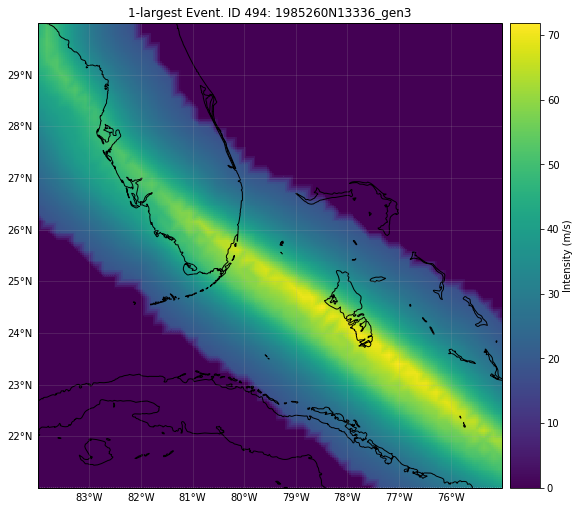

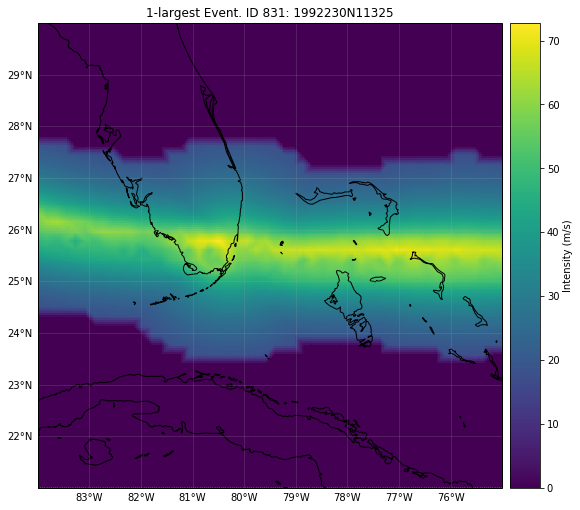

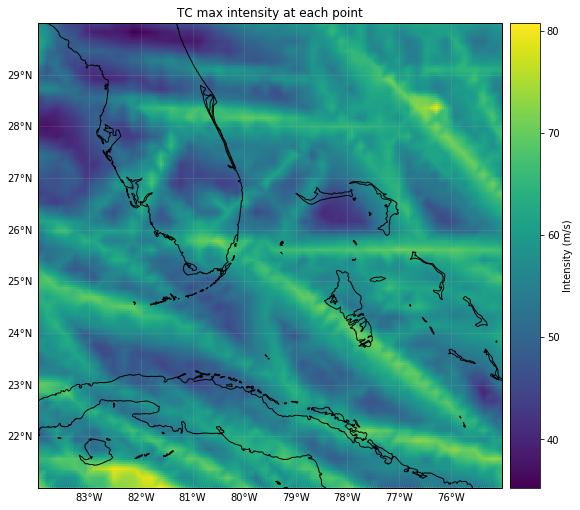

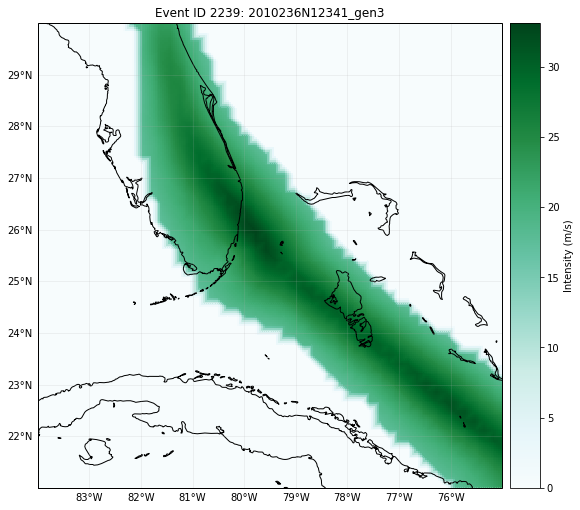

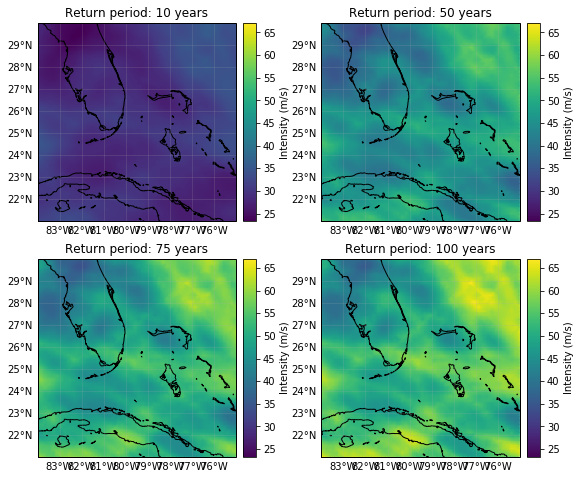

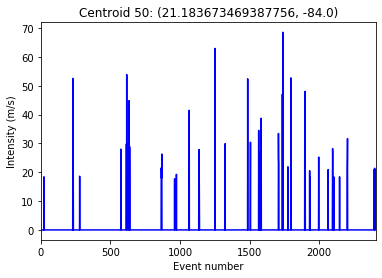

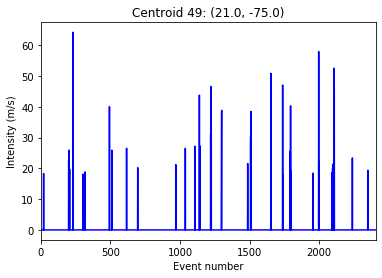

In [11]:
# 1. intensities of the largest event (defined as greater sum of intensities):
# all events:
haz_tc_fl.plot_intensity(event=-1) # 1985260N13336_gen3 is a synthetic event
# only historical events:
haz_tc_fl.select(orig=True).plot_intensity(-1) # largest historical event: 1992230N11325 hurricane ANDREW

# 2. maximum intensities at each centroid:
haz_tc_fl.plot_intensity(event=0)

# 3. intensities of hurricane 2010236N12341_gen3:
haz_tc_fl.plot_intensity(event='2010236N12341_gen3', cmap='BuGn') # setting color map

# 4. tropical cyclone intensities maps for the return periods [10, 50, 75, 100]
_, res = haz_tc_fl.plot_rp_intensity([10, 50, 75, 100])

# 5. intensities of all the events in centroid with id 50
haz_tc_fl.plot_intensity(centr=50)

# 6. intensities of all the events in centroid closest to lat, lon = (26.5, -81)
haz_tc_fl.plot_intensity(centr=(26.5, -81));

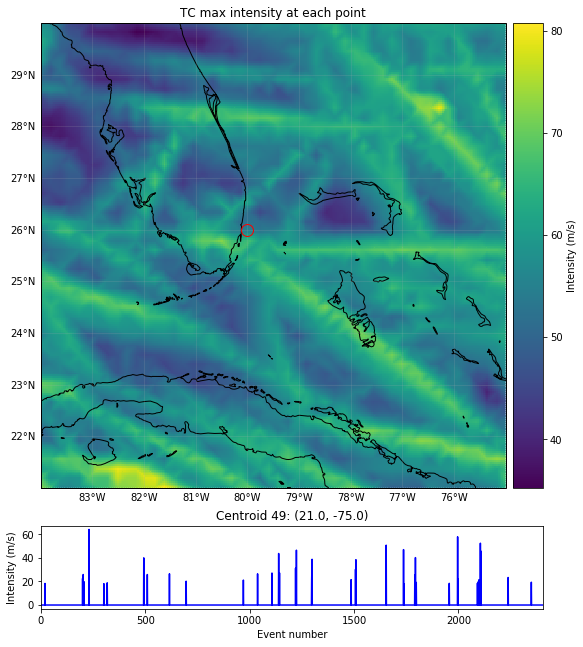

In [12]:
# 7. one figure with two plots: maximum intensities and selected centroid with all intensities:
from climada.util.plot import make_map
import matplotlib.pyplot as plt
plt.ioff()
fig, ax1 = make_map(1)  # map
ax2 = fig.add_subplot(2, 1, 2) # add regular axes
haz_tc_fl.plot_intensity(axis=ax1, event=0) # plot original resolution
ax1.plot(-80, 26, 'or', mfc='none', markersize=12)
haz_tc_fl.plot_intensity(axis=ax2, centr=(26, -80))
fig.subplots_adjust(hspace=6.5)

## Write a hazard

Hazards can be written and read in hdf5 format as follows:

In [13]:
haz_tc_fl.write_hdf5('results/haz_tc_fl.h5')

haz = Hazard('TC')
haz.read_hdf5('results/haz_tc_fl.h5')
haz.check()

2019-10-29 21:57:39,316 - climada.hazard.base - INFO - Writting results/haz_tc_fl.h5
2019-10-29 21:57:40,229 - climada.hazard.base - INFO - Reading results/haz_tc_fl.h5


GeoTiff data is generated using `write_raster()`:

In [14]:
haz_ven.write_raster('results/haz_ven.tif') # each event is a band of the tif file

2019-10-29 21:57:40,264 - climada.util.coordinates - INFO - Writting results/haz_ven.tif


Pickle will work as well:

In [15]:
from climada.util.save import save
# this generates a results folder in the current path and stores the output there
save('tutorial_haz_tc_fl.p', haz_tc_fl)

2019-10-29 21:57:40,332 - climada.util.save - INFO - Written file /Users/aznarsig/Documents/Python/climada_python/doc/tutorial/results/tutorial_haz_tc_fl.p
